In [1]:
import yfinance as yf
import pandas as pd
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [9]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'NVDA', 'JPM', 'V', 'DIS', 'NFLX']
start_date = '2020-01-01'
end_date = '2024-01-01'

data_dir = "data"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

data_dict = {}
for ticker in tickers:
    file_path = os.path.join(data_dir, f"{ticker}.csv")
    print(f"下載 {ticker} 的資料...")
    df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)
    data_dict[ticker] = df

# 測試：印出某隻股票的前五筆資料
print(data_dict['AAPL'].head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

下載 AAPL 的資料...
下載 MSFT 的資料...
下載 GOOGL 的資料...
下載 AMZN 的資料...
下載 TSLA 的資料...
下載 NVDA 的資料...
下載 JPM 的資料...
下載 V 的資料...
下載 DIS 的資料...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


下載 NFLX 的資料...
Price       Adj Close      Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                                        
2020-01-02  72.716064  75.087502  75.150002  73.797501  74.059998  135480400
2020-01-03  72.009117  74.357498  75.144997  74.125000  74.287498  146322800
2020-01-06  72.582901  74.949997  74.989998  73.187500  73.447502  118387200
2020-01-07  72.241554  74.597504  75.224998  74.370003  74.959999  108872000
2020-01-08  73.403648  75.797501  76.110001  74.290001  74.290001  132079200


In [10]:
# 定義技術指標計算函數
def compute_technical_indicators(df):
    df = df.copy()
    # 移動平均線
    df['MA10'] = df['Close'].rolling(window=10).mean()
    df['MA50'] = df['Close'].rolling(window=50).mean()
    
    # RSI (14 天)
    delta = df['Close'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / (avg_loss + 1e-6)
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # Bollinger Bands (20 天)
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['STD20'] = df['Close'].rolling(window=20).std()
    df['Bollinger_Upper'] = df['MA20'] + 2 * df['STD20']
    df['Bollinger_Lower'] = df['MA20'] - 2 * df['STD20']
    
    df.dropna(inplace=True)
    return df

# 為每支股票計算技術指標
for ticker in tickers:
    data_dict[ticker] = compute_technical_indicators(data_dict[ticker])

# 取所有股票的共同日期（避免因交易日不同而導致對齊問題）
common_dates = set.intersection(*[set(df.index) for df in data_dict.values()])
common_dates = sorted(list(common_dates))
for ticker in tickers:
    data_dict[ticker] = data_dict[ticker].loc[common_dates]

## data process

In [11]:
# 設定使用之特徵
features_list = ['Close', 'Volume', 'MA10', 'MA50', 'RSI', 'Bollinger_Upper', 'Bollinger_Lower']
num_features = len(features_list)
num_stocks = len(tickers)

# 使用滑動視窗法構建資料樣本：以過去 30 日數據預測第 31 日收盤價
window_size = 30
num_samples = len(common_dates) - window_size

# 初始化 X 與 y
# X 的 shape 為 (num_samples, num_stocks, window_size, num_features)
# y 的 shape 為 (num_samples, num_stocks)
X = np.zeros((num_samples, num_stocks, window_size, num_features))
y = np.zeros((num_samples, num_stocks))

for stock_idx, ticker in enumerate(tickers):
    df = data_dict[ticker]
    data_array = df[features_list].values  # shape (T, num_features)
    close_array = df['Close'].values         # shape (T,)
    for i in range(num_samples):
        X[i, stock_idx] = data_array[i:i+window_size]
        y[i, stock_idx] = close_array[i+window_size]  # 預測下一日收盤價

# 標準化特徵（所有樣本共用一組 scaler）
scaler = StandardScaler()
X_reshaped = X.reshape(-1, num_features)
X_scaled = scaler.fit_transform(X_reshaped)
X = X_scaled.reshape(num_samples, num_stocks, window_size, num_features)

# 切分訓練/測試集（80% 訓練，20% 測試）
split_idx = int(num_samples * 0.8)
X_train = X[:split_idx]
y_train = y[:split_idx]
X_test = X[split_idx:]
y_test = y[split_idx:]

/tmp/ipykernel_2151/1612388131.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[i, stock_idx] = close_array[i+window_size]  # 預測下一日收盤價
/tmp/ipykernel_2151/1612388131.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[i, stock_idx] = close_array[i+window_size]  # 預測下一日收盤價
/tmp/ipykernel_2151/1612388131.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[i, stock_idx] = close_array[i+window_size]  # 預測下一日收盤價
/tmp/ipykernel_2151/1612388131.py:22: Deprecat

In [12]:
class StockDataset(Dataset):
    def __init__(self, X, y):
        # X: (num_samples, num_stocks, window_size, features)
        # y: (num_samples, num_stocks)
        self.X = X
        self.y = y
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = StockDataset(X_train, y_train)
test_dataset = StockDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [13]:
# 使用訓練集期間的收盤價來計算各股票間皮爾遜相關係數
train_dates = common_dates[window_size:split_idx+window_size]  # 標籤開始的日期
prices_train = []
for ticker in tickers:
    df = data_dict[ticker]
    prices = df['Close'].loc[train_dates].values
    prices_train.append(prices)
prices_train = np.array(prices_train)  # shape: (num_stocks, num_train_days)
prices_train = np.squeeze(prices_train, axis=-1) #不知道為啥多一維

corr_matrix = np.corrcoef(prices_train)
threshold = 0.5
# 構造鄰接矩陣：若相關係數絕對值大於門檻則視為連接
adj_matrix = (np.abs(corr_matrix) > threshold).astype(np.float32)
# 加入自迴路
np.fill_diagonal(adj_matrix, 1.0)
adj_tensor = torch.tensor(adj_matrix)

## Model defined

In [14]:
# 4.1 Transformer 模組（處理時間序列）
class TimeSeriesTransformer(nn.Module):
    def __init__(self, feature_size, d_model, nhead, num_layers, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()
        self.input_linear = nn.Linear(feature_size, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
    def forward(self, x):
        # x: (batch, seq_len, feature_size)
        x = self.input_linear(x)         # (batch, seq_len, d_model)
        x = x.transpose(0, 1)            # (seq_len, batch, d_model)
        x = self.transformer_encoder(x)  # (seq_len, batch, d_model)
        x = x.mean(dim=0)                # (batch, d_model) 使用均值池化
        return x

In [ ]:


# 4.2 GAT 模組（學習股票間關聯）
class GraphAttentionLayer(nn.Module):
    def __init__(self, in_features, out_features, dropout=0.1, alpha=0.2):
        super(GraphAttentionLayer, self).__init__()
        self.W = nn.Linear(in_features, out_features, bias=False)
        self.a = nn.Linear(2*out_features, 1, bias=False)
        self.leakyrelu = nn.LeakyReLU(alpha)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, h, adj):
        # h: (N, in_features)，其中 N 為股票數
        Wh = self.W(h)  # (N, out_features)
        N = Wh.size(0)
        # 計算所有節點對的 attention 分數
        # 先組合所有 (Wh_i || Wh_j)
        a_input = torch.cat([Wh.repeat(1, N).view(N*N, -1), Wh.repeat(N, 1)], dim=1)
        a_input = a_input.view(N, N, -1)  # (N, N, 2*out_features)
        e = self.leakyrelu(self.a(a_input)).squeeze(2)  # (N, N)
        
        # 掩蔽非鄰居節點：將無連接處的分數設為 -inf
        zero_vec = -9e15 * torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)
        attention = F.softmax(attention, dim=1)
        attention = self.dropout(attention)
        h_prime = torch.matmul(attention, Wh)
        return h_prime, attention

# 4.3 融合層：將 Transformer 與 GAT 的輸出結合
class FusionMLP(nn.Module):
    def __init__(self, in_features, hidden_size, out_features):
        super(FusionMLP, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_features, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, out_features)
        )
    def forward(self, x):
        return self.mlp(x)
    
# 4.4 完整 TGNN 模型：對每支股票先用 Transformer 得到時間特徵，再利用 GAT 學習股票間關聯，最後融合預測未來收盤價
class TGNN(nn.Module):
    def __init__(self, feature_size, d_model, nhead, num_layers, gat_hidden, fusion_hidden):
        super(TGNN, self).__init__()
        self.transformer = TimeSeriesTransformer(feature_size, d_model, nhead, num_layers)
        self.gat = GraphAttentionLayer(d_model, gat_hidden)
        # 融合層輸入為 [Transformer 輸出 (d_model) || GAT 輸出 (gat_hidden)]
        self.fusion = FusionMLP(d_model + gat_hidden, fusion_hidden, 1)  # 每支股票預測一個數值
        
    def forward(self, x, adj):
        # x: (num_stocks, window_size, feature_size)
        num_stocks = x.size(0)
        transformer_outputs = []
        # 分別處理每支股票的時間序列
        for i in range(num_stocks):
            xi = x[i].unsqueeze(0)  # (1, window_size, feature_size)
            hi = self.transformer(xi)  # (1, d_model)
            transformer_outputs.append(hi)
        transformer_outputs = torch.cat(transformer_outputs, dim=0)  # (num_stocks, d_model)
        
        # 利用 GAT 模組捕捉股票間關聯
        gat_output, _ = self.gat(transformer_outputs, adj)
        # 融合兩者資訊
        fusion_input = torch.cat([transformer_outputs, gat_output], dim=1)  # (num_stocks, d_model + gat_hidden)
        prediction = self.fusion(fusion_input)  # (num_stocks, 1)
        prediction = prediction.squeeze(1)       # (num_stocks)
        return prediction

In [15]:
class TransformerOnlyModel(nn.Module):
    def __init__(self, feature_size, d_model, nhead, num_layers, dropout=0.1):
        super(TransformerOnlyModel, self).__init__()
        self.transformer = TimeSeriesTransformer(feature_size, d_model, nhead, num_layers, dropout)
        self.out = nn.Linear(d_model, 1)  # 每檔股票最後輸出一個數值（未來股價或報酬等）
    
    def forward(self, x):
        """
        x shape: (num_stocks, window_size, feature_size)
        這裡的作法是逐檔股票分別跑一次 Transformer，再將結果合併。
        """
        num_stocks = x.size(0)
        outputs = []
        for i in range(num_stocks):
            xi = x[i].unsqueeze(0)    # (1, window_size, feature_size)
            hi = self.transformer(xi) # (1, d_model)
            out_i = self.out(hi)      # (1, 1)
            outputs.append(out_i)
        # 將每檔股票的預測結果合併成 (num_stocks,) 向量
        predictions = torch.cat(outputs, dim=0).squeeze(1)  # (num_stocks)
        return predictions


## Train

In [16]:
import torch.nn.functional as F
from torch import optim
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 超參數設定
feature_size = 7   # 例如你有 Close, Volume, MA10, MA50, RSI, Bollinger_Upper, Bollinger_Lower
d_model = 64
nhead = 4
num_layers = 2
dropout = 0.1

model = TransformerOnlyModel(feature_size, d_model, nhead, num_layers, dropout).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
train_losses = []
test_losses = []

print("開始訓練(只有 Transformer)...")
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device).float()  # shape: (batch, num_stocks, window_size, feature_size)
        batch_y = batch_y.to(device).float()  # shape: (batch, num_stocks)

        optimizer.zero_grad()
        # 逐筆樣本處理
        batch_loss = 0.0
        for i in range(batch_X.size(0)):
            x_sample = batch_X[i]  # (num_stocks, window_size, feature_size)
            y_sample = batch_y[i]  # (num_stocks)
            pred = model(x_sample) # (num_stocks)
            loss = criterion(pred, y_sample)
            batch_loss += loss
        
        batch_loss = batch_loss / batch_X.size(0)
        batch_loss.backward()
        optimizer.step()
        
        train_loss += batch_loss.item() * batch_X.size(0)
    
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}")

    # 計算測試集損失
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X = batch_X.to(device).float()
            batch_y = batch_y.to(device).float()
            batch_loss = 0.0
            for i in range(batch_X.size(0)):
                x_sample = batch_X[i]
                y_sample = batch_y[i]
                pred = model(x_sample)
                loss = criterion(pred, y_sample)
                batch_loss += loss
            batch_loss = batch_loss / batch_X.size(0)
            test_loss += batch_loss.item() * batch_X.size(0)
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Test Loss: {test_loss:.4f}")
    model.train()

# 繪製訓練損失和測試損失
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Test Loss (Only Transformer)')
plt.show()


/home/kenny1208/anaconda3/envs/Torch/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


開始訓練(只有 Transformer)...
Epoch 1/50, Train Loss: 44470.2751
Epoch 1/50, Test Loss: 46959.8863
Epoch 2/50, Train Loss: 43748.1565
Epoch 2/50, Test Loss: 46250.9624
Epoch 3/50, Train Loss: 43024.2286
Epoch 3/50, Test Loss: 45423.2193
Epoch 4/50, Train Loss: 42203.8555
Epoch 4/50, Test Loss: 44488.0259
Epoch 5/50, Train Loss: 41287.0360
Epoch 5/50, Test Loss: 43457.9168
Epoch 6/50, Train Loss: 40289.4800
Epoch 6/50, Test Loss: 42336.5753
Epoch 7/50, Train Loss: 39219.6423
Epoch 7/50, Test Loss: 41133.7917
Epoch 8/50, Train Loss: 38084.6521
Epoch 8/50, Test Loss: 39865.9916
Epoch 9/50, Train Loss: 36895.4139
Epoch 9/50, Test Loss: 38546.1020


KeyboardInterrupt: 

In [ ]:
# 測試
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device).float()
        batch_y = batch_y.to(device).float()
        for i in range(batch_X.size(0)):
            x_sample = batch_X[i]
            y_sample = batch_y[i]
            pred = model(x_sample)
            all_preds.append(pred.cpu().numpy())
            all_labels.append(y_sample.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

rmse = np.sqrt(mean_squared_error(all_labels.flatten(), all_preds.flatten()))
mae  = mean_absolute_error(all_labels.flatten(), all_preds.flatten())
r2   = r2_score(all_labels.flatten(), all_preds.flatten())

print(f"\n(Only Transformer) Test RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

### hybird

/home/kenny1208/anaconda3/envs/Torch/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


開始訓練...
Epoch 1/50, Train Loss: 44587.9990
Epoch 1/50, Test Loss: 45232.2757
Epoch 2/50, Train Loss: 38282.5768
Epoch 2/50, Test Loss: 32988.5565
Epoch 3/50, Train Loss: 23317.6559
Epoch 3/50, Test Loss: 14817.0525
Epoch 4/50, Train Loss: 11657.8856
Epoch 4/50, Test Loss: 5777.9952
Epoch 5/50, Train Loss: 8019.2314
Epoch 5/50, Test Loss: 5338.6648
Epoch 6/50, Train Loss: 7157.2789
Epoch 6/50, Test Loss: 3402.1003
Epoch 7/50, Train Loss: 5095.0245
Epoch 7/50, Test Loss: 2649.8622
Epoch 8/50, Train Loss: 4214.4008
Epoch 8/50, Test Loss: 2474.3503
Epoch 9/50, Train Loss: 3522.5104
Epoch 9/50, Test Loss: 2850.5775
Epoch 10/50, Train Loss: 3359.2849
Epoch 10/50, Test Loss: 2040.3230
Epoch 11/50, Train Loss: 2740.5791
Epoch 11/50, Test Loss: 1974.6245
Epoch 12/50, Train Loss: 2244.7951
Epoch 12/50, Test Loss: 1646.3481
Epoch 13/50, Train Loss: 2240.1051
Epoch 13/50, Test Loss: 1351.8825
Epoch 14/50, Train Loss: 1775.7283
Epoch 14/50, Test Loss: 1090.8639
Epoch 15/50, Train Loss: 1660.9697
Ep

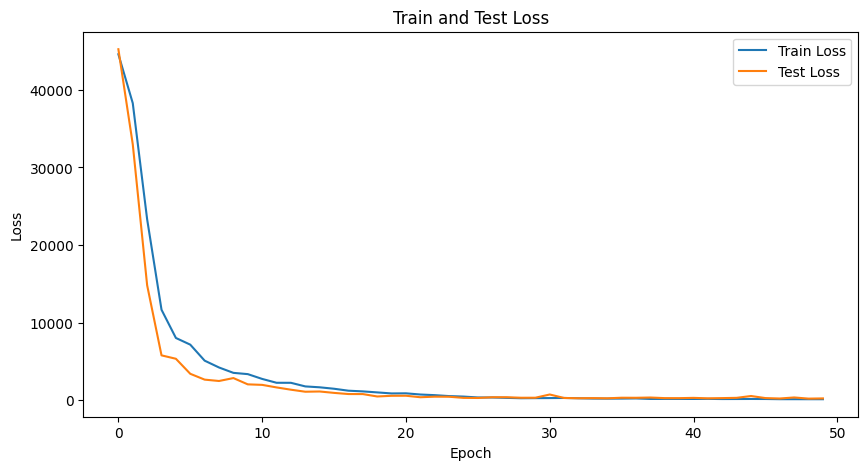

In [16]:
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 模型超參數設定
feature_size = num_features
d_model = 64
nhead = 4
num_layers = 2
gat_hidden = 32
fusion_hidden = 64

# 實例化模型
model = TGNN(feature_size, d_model, nhead, num_layers, gat_hidden, fusion_hidden).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50

train_losses = []
test_losses = []

print("開始訓練...")
model.train()
for epoch in range(num_epochs):
    train_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device).float()
        batch_y = batch_y.to(device).float()
        
        optimizer.zero_grad()
        batch_loss = 0.0
        for i in range(batch_X.size(0)):
            x_sample = batch_X[i]
            y_sample = batch_y[i]
            pred = model(x_sample, adj_tensor.to(device))
            loss = criterion(pred, y_sample)
            batch_loss += loss
        batch_loss = batch_loss / batch_X.size(0)
        batch_loss.backward()
        optimizer.step()
        train_loss += batch_loss.item() * batch_X.size(0)
    train_loss /= len(train_dataset)
    train_losses.append(train_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}")

    # 計算測試集損失
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X = batch_X.to(device).float()
            batch_y = batch_y.to(device).float()
            batch_loss = 0.0
            for i in range(batch_X.size(0)):
                x_sample = batch_X[i]
                y_sample = batch_y[i]
                pred = model(x_sample, adj_tensor.to(device))
                loss = criterion(pred, y_sample)
                batch_loss += loss
            batch_loss = batch_loss / batch_X.size(0)
            test_loss += batch_loss.item() * batch_X.size(0)
    test_loss /= len(test_dataset)
    test_losses.append(test_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Test Loss: {test_loss:.4f}")
    model.train()

# 繪製訓練損失和測試損失
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Test Loss')
plt.show()

In [19]:
model_save_path = "tgnn_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to tgnn_model.pth


In [17]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device).float()
        batch_y = batch_y.to(device).float()
        for i in range(batch_X.size(0)):
            x_sample = batch_X[i]
            y_sample = batch_y[i]
            pred = model(x_sample, adj_tensor.to(device))
            all_preds.append(pred.cpu().numpy())
            all_labels.append(y_sample.cpu().numpy())

all_preds = np.array(all_preds)    # (num_test_samples, num_stocks)
all_labels = np.array(all_labels)  # (num_test_samples, num_stocks)

# 評估指標計算
rmse = np.sqrt(mean_squared_error(all_labels.flatten(), all_preds.flatten()))
mae  = mean_absolute_error(all_labels.flatten(), all_preds.flatten())
r2   = r2_score(all_labels.flatten(), all_preds.flatten())
print(f"\nTest RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")


Test RMSE: 15.1932, MAE: 9.9602, R2: 0.9807
